# Search Evaluation Notebook

This python notebook will perform a search evaluation
Prerequisites:
* Golden data set in file ```golden_data.csv```
* Search strategies in python modules located in the ```strategies``` folder

In [1]:
# Export the API key to an environment variable
import os, subprocess

openai_api_key = "YOUR KEY HERE"
openai_api_base = "https://llm-proxy.prod-3.eden.elastic.dev/v1"

os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ["OPENAI_BASE_URL"] = openai_api_base

subprocess.run([
    "deepeval", "set-local-model", 
    "--model-name=gpt-4o", 
    f"--base-url={openai_api_base}", 
    f"--api-key={openai_api_key}"
    f""])

# ## Uncomment the following lines if you want to use .env file to control settings
# from dotenv import load_dotenv
# load_dotenv()   


True

In [2]:
### What files to work with
GOLDEN_DATA_CSV = "golden_data.csv"
STRATEGIES_FOLDER = "strategies"
SEARCH_OUTPUT_JSON = "results_search_evaluation.json"
DEEPEVAL_OUTPUT_JSON = "results_deepeval_results.json"

In [3]:
## Run the Evaluation

from utility.util_es import get_es
from utility.util_vis_result import vis_search_eval_json, vis_deep_eval_correct_tests
from evaluate import run_search_evaluation, load_golden_data, load_strategies, output_search_eval_results

# https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html
print("### Starting evaluation using Elasticsearch _rank_eval API")

# 1. Connect to Elasticsearch
es = get_es()
print(f"\tConnected to Elasticsearch version: {es.info()['version']['number']}")

# 2. Load the golden data set
golden_data = load_golden_data(GOLDEN_DATA_CSV)
print(f"\tIdentified {len(golden_data)} golden data entry(ies) to use for search evaluation")

# 3. Load strategies from the strategies folder
strategy_modules = load_strategies(STRATEGIES_FOLDER)  
print(f"\tIdentified {len(strategy_modules)} strategy(ies) to evaluate")

# 4. Evaluate each strategy
results = run_search_evaluation(es, golden_data, strategy_modules)

# 5. Output the evaluation results
output_search_eval_results(SEARCH_OUTPUT_JSON, results, golden_data, strategy_modules)



Using ES with configured Host and API key
### Starting evaluation using Elasticsearch _rank_eval API
	Connected to Elasticsearch version: 8.17.0
	Identified 18 golden data entry(ies) to use for search evaluation
	Identified 4 strategy(ies) to evaluate
### SEARCH RANK EVAL
	Skipping strategy: 4_e5
	Starting strategy: 5_e5_hybrid
	Starting strategy: 6_e5_hybrid_qt
	Starting strategy: 7_e5_reranker
### Evaluation complete. 
	Results written to  results_search_evaluation.json


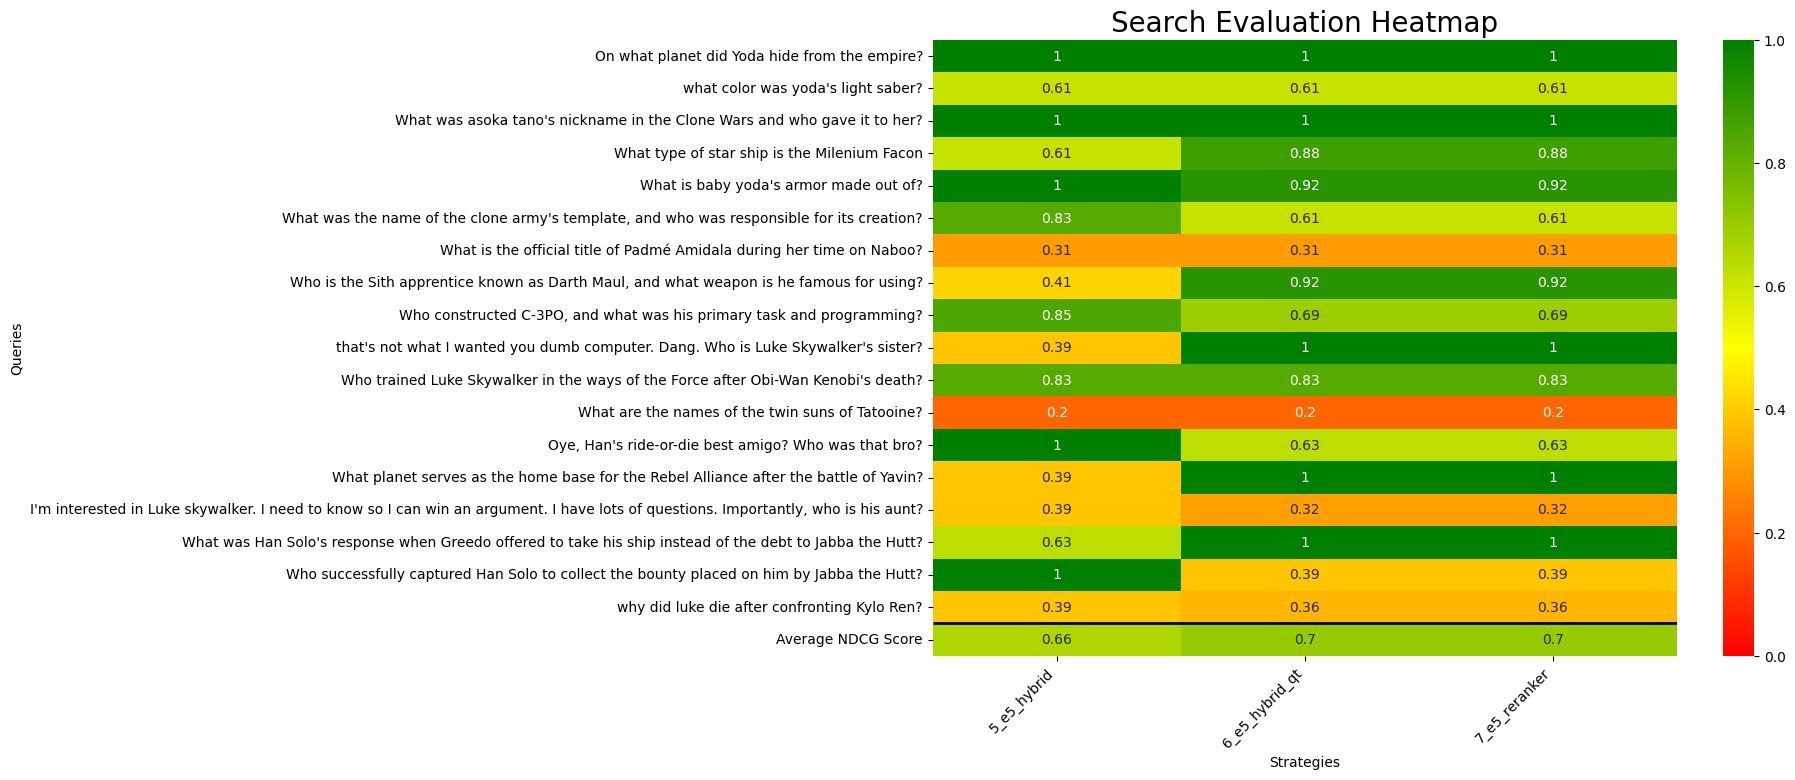

In [4]:
## Visualize the Results of the Evaluation
# 6. Visualize
vis_search_eval_json(SEARCH_OUTPUT_JSON)

In [5]:
from evaluate import run_deepeval, output_deepeval_results

import json

# startegies to Evauate
# include_strategy_names = ["3b_e5_hybrid", "3b_e5_hybrid_qt"]


## Deep Eval Evaluation
print("### DEEP EVAL")
es = get_es()

rag_system_prompt = """
Instructions:

- You are an assistant for question-answering tasks.
- Answer questions truthfully and factually using only the context presented.
- Do not jump to conclusions or make assumptions.
- If the answer is not present in the provided context, just say that you don't know rather than making up an answer or using your own knowledge from outside the prompt.
- You must always cite the document where the answer was extracted using inline academic citation style [], using the position or multiple positions. Example:  [1][3].
- Use markdown format for code examples or bulleted lists.
- You are correct, factual, precise, and reliable.


Context:
{context}
"""

## Search Top 6 documents, with 3 inner hits per doc, send a max of 9 documents to the LLM for RAG
deepEvalScores = run_deepeval(es, strategy_modules, golden_data, rag_system_prompt,6, 3, 9)


## save the scores to disk
output_deepeval_results(DEEPEVAL_OUTPUT_JSON, deepEvalScores)
print(f"\nDeepEval scores saved to {DEEPEVAL_OUTPUT_JSON}")





### DEEP EVAL
Skipping strategy: 4_e5
Starting strategy: 5_e5_hybrid
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:00, 76.04test case/s]


Starting strategy: 6_e5_hybrid_qt
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:00, 93.45test case/s]


Starting strategy: 7_e5_reranker
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:00, 88.05test case/s]


DeepEval scores saved to results_deepeval_results.json


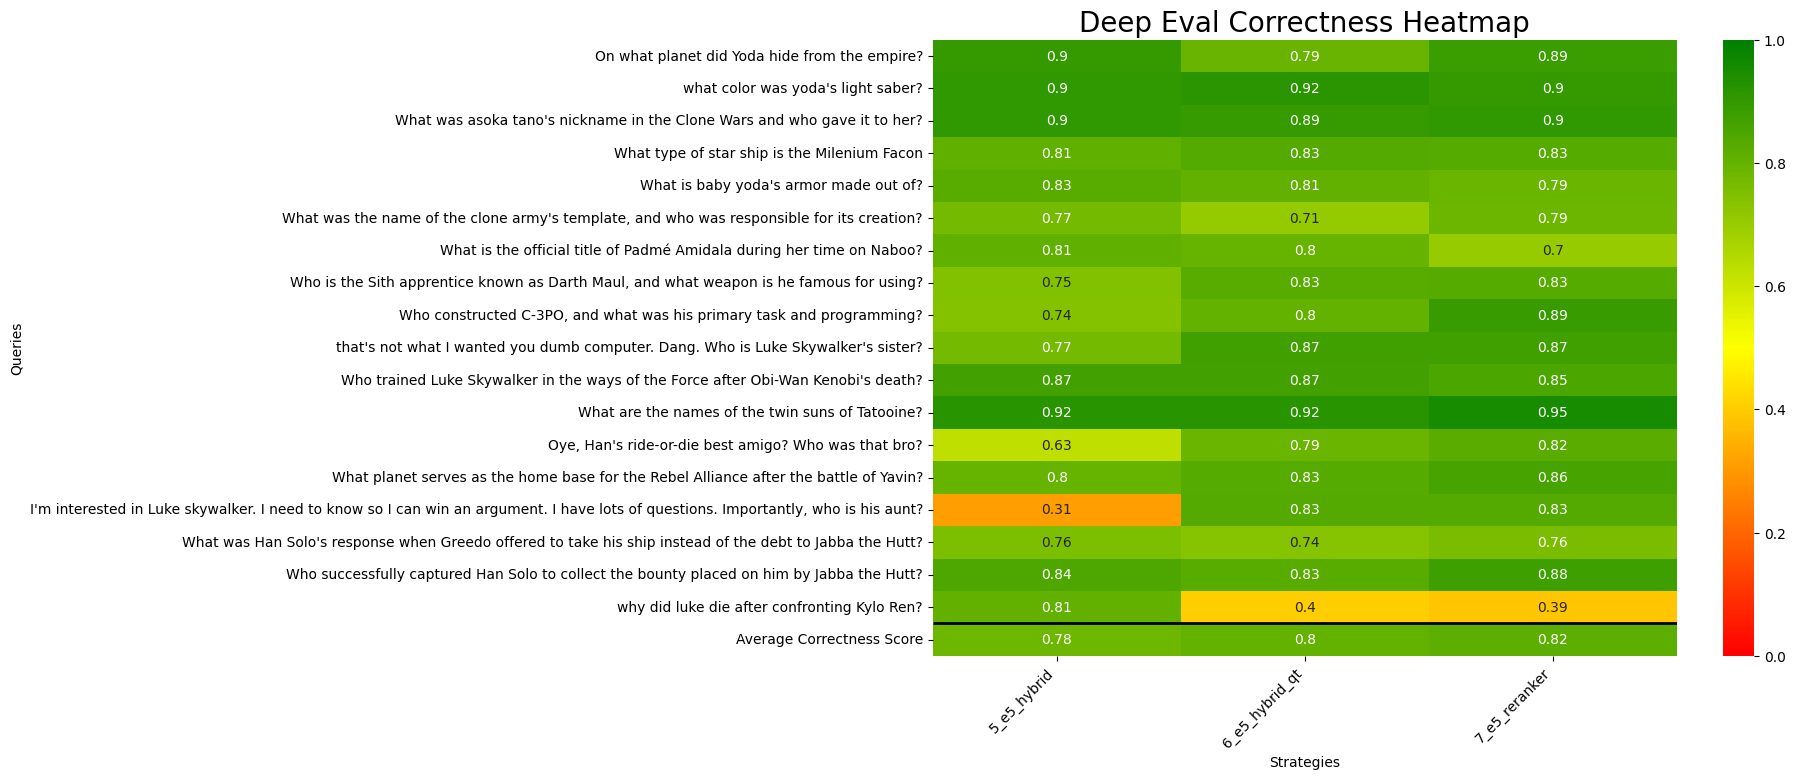

In [6]:
# 6. Visualize
vis_deep_eval_correct_tests(DEEPEVAL_OUTPUT_JSON)

In [7]:
# ## We'll uncomment this in a later Exercise
# ## Here's an alternate RAG setup sending 1/3 the tokens to the LLM to save inferences costs
# ## We should see rescore really shine here

# ## Search Top 3 documents, with 3 inner hits per doc, send a max of 3 documents to the LLM for RAG
# deepEvalScores = run_deepeval(es, strategy_modules, golden_data, rag_system_prompt,3, 3, 3)


# ## save the scores to disk
# output_deepeval_results(f"{DEEPEVAL_OUTPUT_JSON}_2", deepEvalScores)
# print(f"\nDeepEval scores saved to {DEEPEVAL_OUTPUT_JSON}_2")

# vis_deep_eval_correct_tests(f"{DEEPEVAL_OUTPUT_JSON}_2")